In [ ]:
# ..... integrate with STACAS ..... #

In [2]:
library(Seurat)
library(STACAS)
library(dplyr)
library(ggplot2)

In [3]:
# list of stages and samples
stages = rep(c('stage14', 'stage17', 'stage21'), each = 3)
samples = paste0('sample', c('4', '7', '8A', '3_Triangle', '5B', '5Y', '1A', '1B', '2'))

In [4]:
# load cell type anno from MetaMarkers
# tab1 = read.delim('turtle_celltype_annotations.csv', sep = ',')
tab1 = read.delim('turtle_manual_anno1.csv', sep = ',')
tab1$consensus_type = tab1$anno1
tab1[1:2,]

stage           cluster anno1       anno2       anno3       confident
1 stage14_sample4 0       endocardial endocardial endocardial yes      
2 stage14_sample4 1       epicardial  epicardial              no       
  consensus_type
1 endocardial   
2 epicardial

In [5]:
meta.batch <- "dataset"
meta.label <- "consensus_type"

In [6]:
# load data
mat1 = c()
mtd1 = c()
cols1 = c('species', 'dataset', 'consensus_type', 'old_clusters')

for(id3 in 1:length(samples)){
    sc3 = readRDS(paste0(stages[id3], '_', samples[id3], '_data.rds'))
    sc3$dataset = paste0(stages[id3], '_', samples[id3])
    sc3$species = 'turtle'
    sc3$old_clusters = sc3$seurat_clusters

    # add simple cell anno
    # sc3$consensus_type = tab1$consensus_type[match(rownames(sc3@meta.data), tab1$barcode)]
    tab2 = tab1[which(tab1$stage == paste0(stages[id3], '_', samples[id3])),]
    sc3$consensus_type = tab2$consensus_type[match(sc3$seurat_clusters, tab2$cluster)]
    
    mat1 = cbind(mat1, LayerData(sc3, assay = 'RNA', layer = 'counts'))
    mtd1 = rbind(mtd1, sc3@meta.data[,cols1])    
}

In [7]:
sce = CreateSeuratObject(counts = mat1, meta.data = mtd1)

obj.list <- SplitObject(sce, split.by = meta.batch)

In [8]:
for (i in 1:length(obj.list)) {
  obj.list[[i]] <- obj.list[[i]] |>
                  NormalizeData(assay = "RNA") |>
                  FindVariableFeatures(nfeatures = 5000)
}

hvg <- SelectIntegrationFeatures(obj.list, nfeatures = 3000)

Normalizing layer: counts

Finding variable features for layer counts

Normalizing layer: counts

Finding variable features for layer counts

Normalizing layer: counts

Finding variable features for layer counts

Normalizing layer: counts

Finding variable features for layer counts

Normalizing layer: counts

Finding variable features for layer counts

Normalizing layer: counts

Finding variable features for layer counts

Normalizing layer: counts

Finding variable features for layer counts

Normalizing layer: counts

Finding variable features for layer counts

Normalizing layer: counts

Finding variable features for layer counts



In [ ]:
object.ss <- Run.STACAS(obj.list, dims = 1:30,
                        anchor.features = hvg,
                        cell.labels = "consensus_type")            

Preparing PCA embeddings for objects...



In [11]:
object.ss <- FindNeighbors(object.ss, dims = 1:30)
object.ss <- FindClusters(object.ss, resolution = 1)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 68775
Number of edges: 2730189

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9220
Number of communities: 34
Elapsed time: 18 seconds


1 singletons identified. 33 final clusters.



In [12]:
object.ss <- RunUMAP(object.ss, dims = 1:30)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
15:52:27 UMAP embedding parameters a = 0.9922 b = 1.112

15:52:27 Read 68775 rows and found 20 numeric columns

15:52:27 Using Annoy for neighbor search, n_neighbors = 30

15:52:27 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

15:52:35 Writing NN index file to temp file /tmp/Rtmp5KMCEw/file24f8ae49fe3d2f

15:52:35 Searching Annoy index using 1 thread, search_k = 3000

15:52:57 Annoy recall = 100%

15:52:59 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbor

In [13]:
object.ss@meta.data[1,]

orig.ident nCount_RNA nFeature_RNA species
stage14_sample4_AAACCCACAATGAACA-1 stage14    3281       1926         turtle 
                                   dataset         consensus_type  
stage14_sample4_AAACCCACAATGAACA-1 stage14_sample4 Endothelial_cell
                                   integrated_snn_res.1 seurat_clusters
stage14_sample4_AAACCCACAATGAACA-1 4                    4

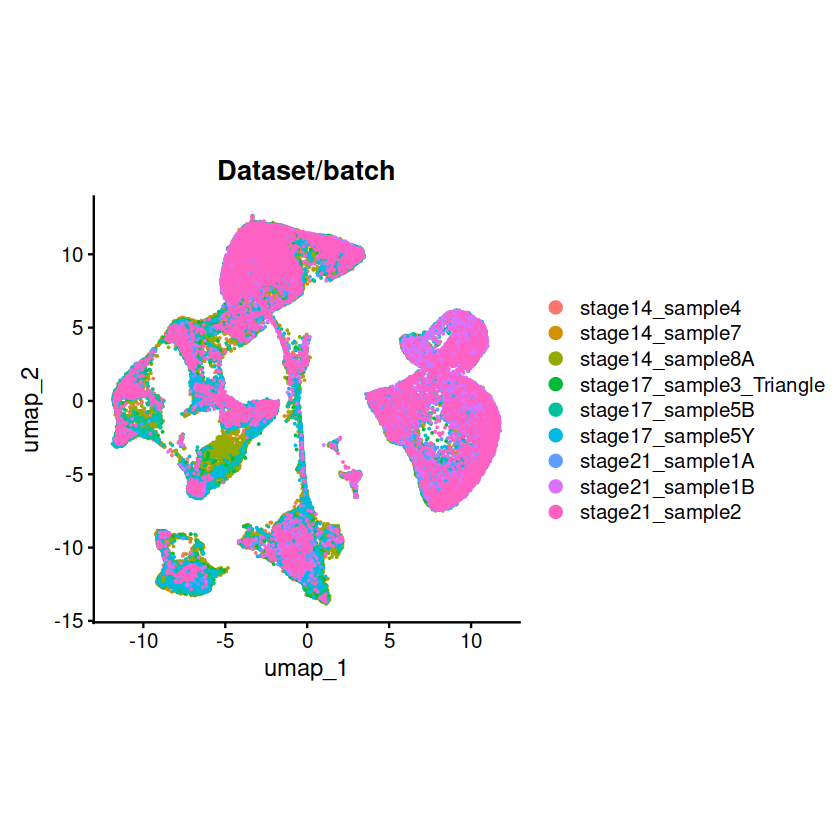

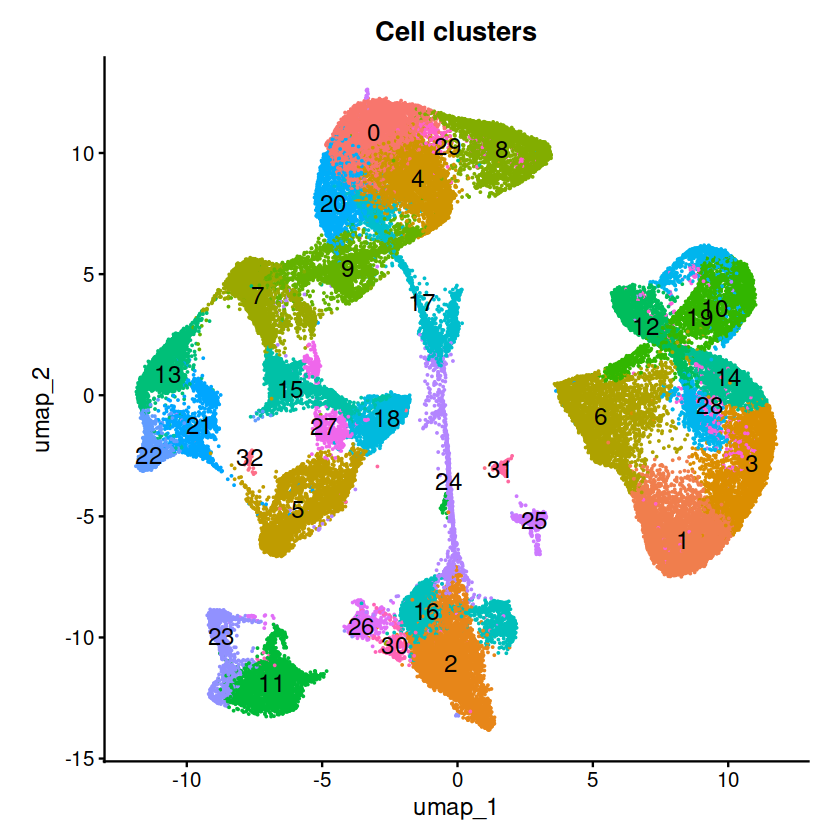

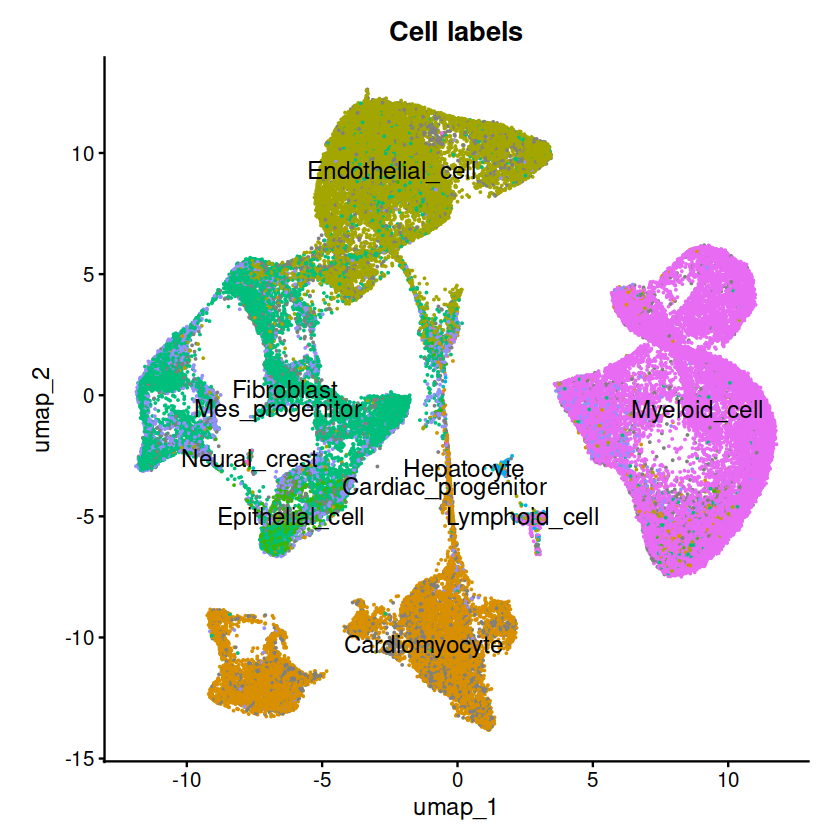

In [14]:
DimPlot(object.ss, group.by = meta.batch) + theme(aspect.ratio = 1) + ggtitle("Dataset/batch")
DimPlot(object.ss, group.by = 'seurat_clusters', label=T, label.size = 5) + NoLegend() + 
theme(aspect.ratio = 1) + ggtitle("Cell clusters")
DimPlot(object.ss, group.by = meta.label, label=T, label.size = 5) + NoLegend() +
theme(aspect.ratio = 1) + ggtitle("Cell labels")

In [15]:
# save
saveRDS(object.ss, file = 'turtle_integrated_ssSTACAS_v2.rds')

In [ ]:
df = object.ss@reductions$pca@cell.embeddings
rownames(df) = NULL
colnames(df) = NULL
df[1:2,]

In [ ]:
# save umap embeddings for integrated dataset
write.table(df, file = 'turtle_ssSTACAS_embeddings_new2.csv', sep = ',',
           row.names = F, col.names = F, quote = F)